<a href="https://colab.research.google.com/github/rizkiwijanarko/Automated-Image-Captioning/blob/master/Image_Captioning_CNN_%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import os
from os import listdir
from PIL import Image
import string
import pickle
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization,LSTM,Embedding, Bidirectional, LSTM,Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import gc
from textwrap import wrap
import seaborn as sns
import warnings

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/Images'

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/captions.txt/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Feature Extraction

In [ ]:
# Extract
model = InceptionV3(weights='imagenet')
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_658 (Conv2D)         (None, 149, 149, 32)         864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_658 (B  (None, 149, 149, 32)         96        ['conv2d_658[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_658 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_65

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = InceptionV3(weights='imagenet')
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # extract features from each photo
    features = dict()
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        img = load_img(filename, target_size=(299, 299))
        # convert the image to a numpy array
        x = img_to_array(img)
        # reshape data for the model
        x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
        # prepare the image for the Inception model
        x = preprocess_input(x)
        # get features
        feature = model.predict(x, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print('>%s' % name)
    return features

In [ ]:
# extract features from all images
directory = img_path
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
# save to file
pickle.dump(features, open('features.pkl', 'wb'))


In [ ]:
pickle.dump(features, open('features.pkl', 'wb'))

In [ ]:
# # load features
# with open('/content/features.pkl','rb') as f:
#     features = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/features.pkl','rb') as f:
    features = pickle.load(f)

# Data Cleaning

In [ ]:
with open(os.path.join(img_path,'/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/captions.txt/captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

# Preprocess Text

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# process text
clean(mapping)

In [ ]:
mapping

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Tokenize the Content

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
vocab_size

8485

In [ ]:
# get maximum len of the captions available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids)  * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
print(len(train))
print(len(test))

7281
810


# Create Data Generator

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Spllt the squences into x,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq  = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequeces
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

                if n == batch_size:
                    x1,x2,y = np.array(x1), np.array(x2), np.array(y)
                    yield[x1,x2], y
                    x1, x2, y = list(), list(), list()
                    n = 0

# Model Architecture

In [ ]:
import gc
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Bidirectional, LSTM,BatchNormalization,Concatenate

# Encoder model
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

# Decoder
decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=0.0001, clipvalue=5.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

# Train Model

In [ ]:
# Define parameters
model_name = 'model.h5'

epochs = 10
batch_size = 32
steps_per_epoch = len(train) // batch_size
validation_steps = len(test) // batch_size

In [ ]:
train_generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
validation_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)

In [ ]:
# Define callbacks
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

# Training
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/10
227/227 [==============================] - ETA: 0s - loss: 5.7912
Epoch 1: val_loss did not improve from 3.58273
227/227 [==============================] - 130s 448ms/step - loss: 5.7912 - val_loss: 6.1037
Epoch 2/10
227/227 [==============================] - ETA: 0s - loss: 4.3900
Epoch 2: val_loss did not improve from 3.58273
227/227 [==============================] - 94s 413ms/step - loss: 4.3900 - val_loss: 4.4463
Epoch 3/10
227/227 [==============================] - ETA: 0s - loss: 3.8886
Epoch 3: val_loss did not improve from 3.58273
227/227 [==============================] - 94s 416ms/step - loss: 3.8886 - val_loss: 3.9331
Epoch 4/10
227/227 [==============================] - ETA: 0s - loss: 3.5925
Epoch 4: val_loss did not improve from 3.58273
227/227 [==============================] - 94s 413ms/step - loss: 3.5925 - val_loss: 3.7657
Epoch 5/10
227/227 [==============================] - ETA: 0s - loss: 3.3670
Epoch 5: val_loss did not improve from 3.58273
227/227 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 93s 411ms/step - loss: 3.0180 - val_loss: 3.5662
Epoch 8/10
227/227 [==============================] - ETA: 0s - loss: 2.8733
Epoch 8: val_loss improved from 3.56621 to 3.55013, saving model to model_checkpoint.h5
227/227 [==============================] - 94s 414ms/step - loss: 2.8733 - val_loss: 3.5501
Epoch 9/10
227/227 [==============================] - ETA: 0s - loss: 2.7407
Epoch 9: val_loss improved from 3.55013 to 3.54458, saving model to model_checkpoint.h5
227/227 [==============================] - 95s 416ms/step - loss: 2.7407 - val_loss: 3.5446
Epoch 10/10
227/227 [==============================] - ETA: 0s - loss: 2.6200
Epoch 10: val_loss did not improve from 3.54458
227/227 [==============================] - 93s 410ms/step - loss: 2.6200 - val_loss: 3.5512


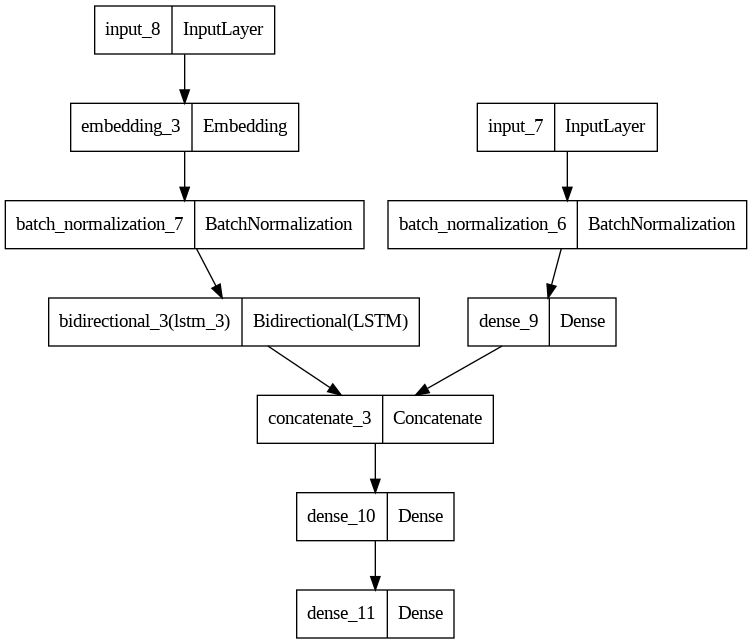

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 35, 512)              4344320   ['input_8[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 2048)                 8192      ['input_7[0][0]']             
 chNormalization)                                                                           

In [ ]:
# Save model
model.save('model.h5')

# Performance Evaluation

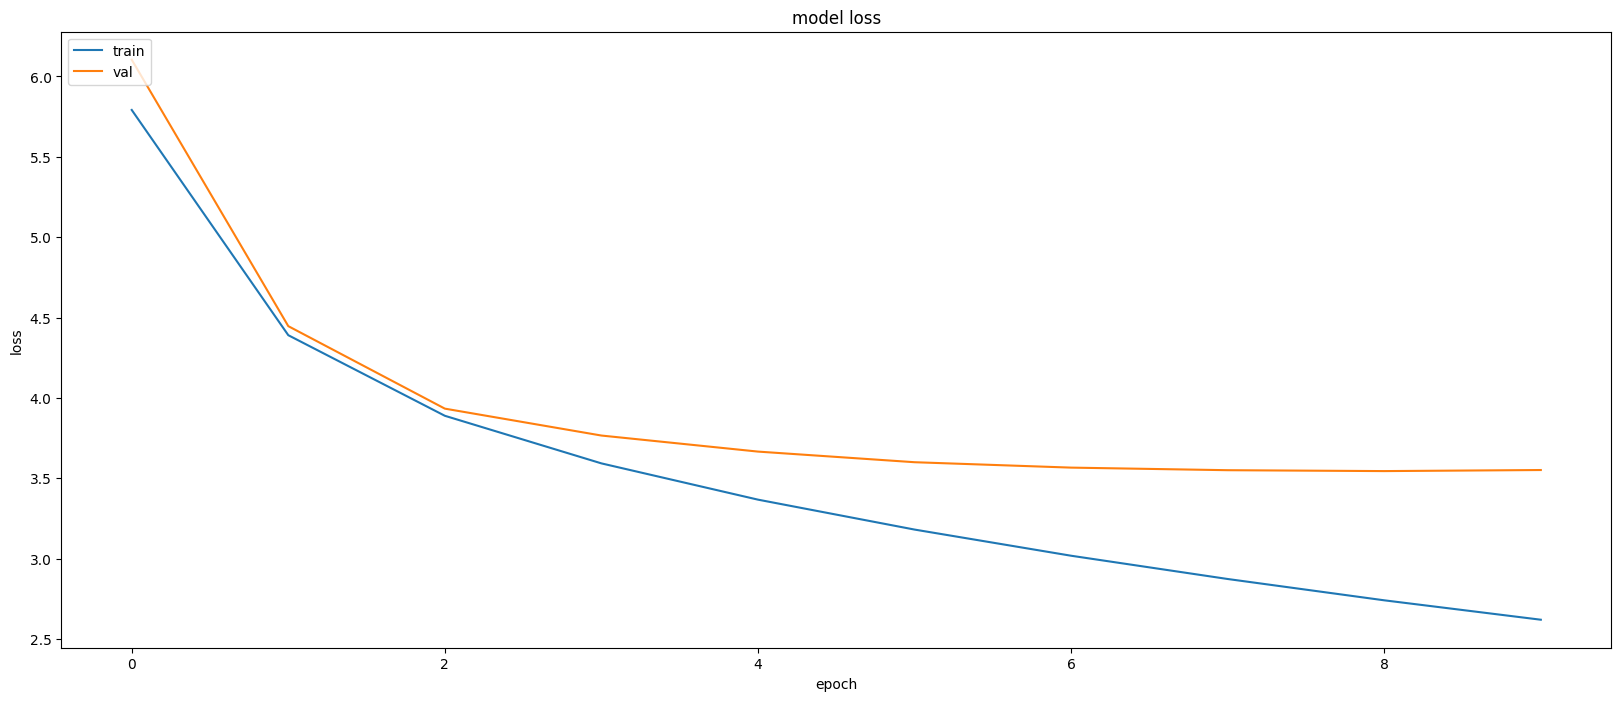

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Caption Generation

In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/Images/{temp_df.image[i]}.jpg")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# Test Model

In [ ]:
# load the tokenizer
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))
# Load Features
with open('/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/features.pkl','rb') as f:
    features = pickle.load(f)
# pre-define the max sequence length (from training)
max_length = 35
# load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Captioning Dataset 2/model_3.55val.h5')

In [ ]:
# Testing the model
sample_df = pd.DataFrame(columns=["image", "caption"])
sample_list = []

# Assuming test is a DataFrame with a column 'image'
for i in range(15):
    image = np.random.choice(test)
    caption = predict_caption(model, image, tokenizer, max_length, features)
    sample_list.append(pd.DataFrame({"image": [image], "caption": [caption]}))

# Concatenate all dataframes in the list
sample_df = pd.concat(sample_list, ignore_index=True)

print(sample_df)


1/1 [==============================] - 0s 86ms/step
                   image                                            caption
0   571130875_30051ac02d  startseq woman in dress walks in front of larg...
1   816084977_21c1811c9a  startseq two dogs are playing in the water endseq
2   454691853_cc1e0fa6a1   startseq dog is running through the grass endseq
3   724702877_f2a938766b  startseq small dog is jumping into the air whi...
4   482882719_165722082d             startseq kayaker in kayak kayak endseq
5    96985174_31d4c6f06d  startseq two people are sitting on mountain in...
6   771366843_a66304161b  startseq man in blue shirt and white hat is si...
7   503090187_8758ab5680               startseq woman taking picture endseq
8   448590900_db83c42006  startseq two dogs are running through grassy f...
9   948196883_e190a483b1  startseq woman in red and white dress is walki...
10  571507143_be346225b7  startseq woman in white shirt and woman in red...
11  967719295_3257695095        star

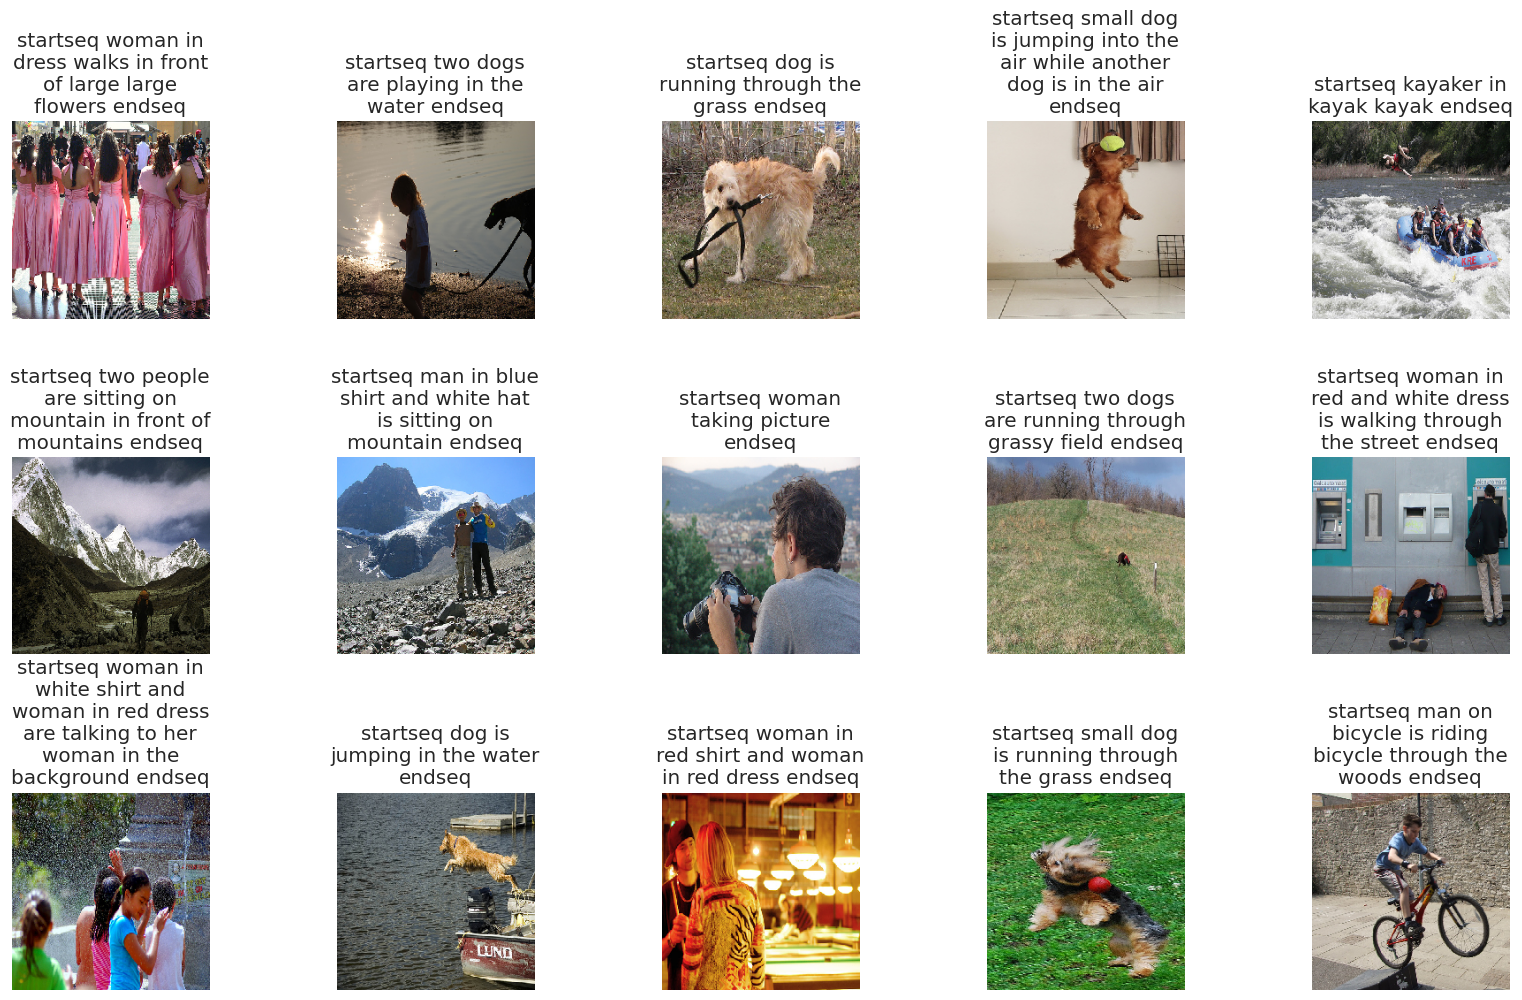

In [ ]:
display_images(sample_df)

In [ ]:
# Evaluate Model with BLEU SCORE
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = predict_caption(model, key, tokenizer, max_length, photos)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
test_features = {image_id: features[image_id] for image_id in test}
test_mapping = {image_id: mapping[image_id] for image_id in test}

In [ ]:
print(len(test_features))
print(len(test_mapping))

In [ ]:
# evaluate model
evaluate_model(model, test_mapping, test_features, tokenizer, max_length)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step
BLEU-1: 0.569193
BLEU-2: 0.350149
BLEU-3: 0.258834
BLEU-4: 0.139472
